In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
def generate_ar_data(n, change_point, mean0, variance0, mean1, variance1, theta):
    """
    生成自回归模型的合成数据
    """
    data = np.zeros(n)
    data[0] = mean0

    # Data before the change point
    for t in range(1, change_point):
        data[t] = data[t-1] + (1 - theta) * (mean0 - data[t-1]) + np.random.normal(0, np.sqrt(variance0))

    # Data after the change point
    for t in range(change_point, n):
        data[t] = data[t-1] + (1 - theta) * (mean1 - data[t-1]) + np.random.normal(0, np.sqrt(variance1))

    return data

In [ ]:
def cusum(data, h):
    """
    Execute the CuSum algorithm and return a list of time points,
    positive and negative cumulative sums at which changes were detected
    """
    s_pos = 0
    s_neg = 0
    s_pos_list = [0]
    s_neg_list = [0]

    for i in range(1, len(data)):
        s_pos = max(0, s_pos + data[i] - data[i-1] - h)
        s_neg = min(0, s_neg + data[i] - data[i-1] + h)

        s_pos_list.append(s_pos)
        s_neg_list.append(s_neg)

        if s_pos >= h or s_neg <= -h:
            return i, s_pos_list, s_neg_list
    return len(data), s_pos_list, s_neg_list

theta = 0.1, Detection Time = 167, Delay = -533
theta = 0.5, Detection Time = 720, Delay = 20
theta = 0.8, Detection Time = 1000, Delay = 300


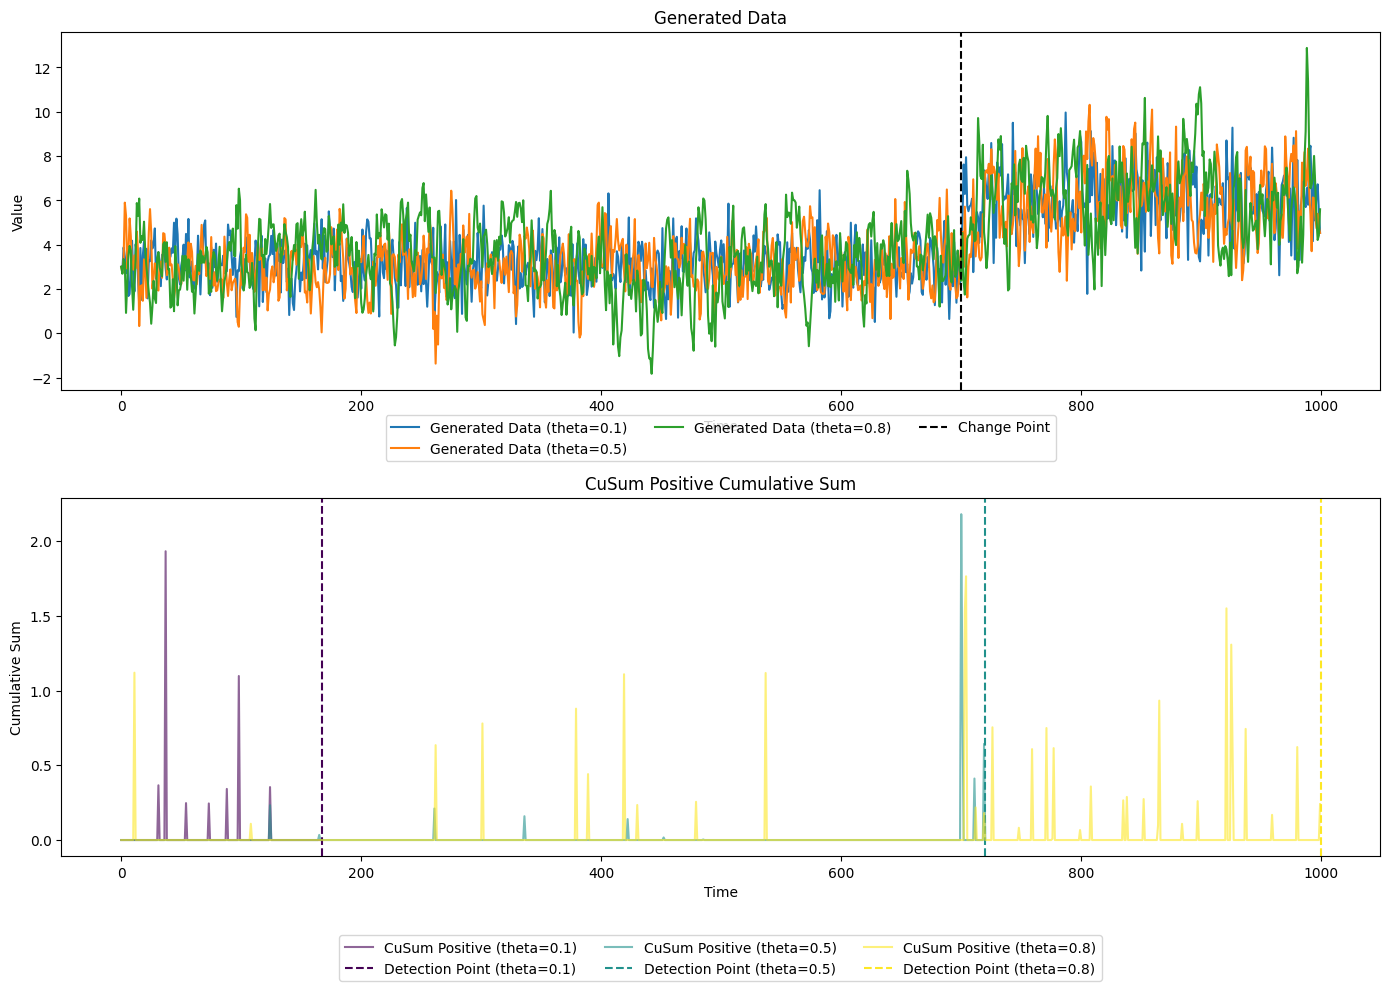

In [ ]:
def run_ar_experiment(n, change_point, mean0, variance0, mean1, variance1, theta_values, h):
    """
    运行自回归数据生成和CuSum检测实验，并可视化结果
    """
    results = {}

    for theta in theta_values:
        data = generate_ar_data(n, change_point, mean0, variance0, mean1, variance1, theta)
        detection_time, s_pos_list, s_neg_list = cusum(data, h)
        delay = detection_time - change_point
        results[theta] = {
            'detection_time': detection_time,
            's_pos_list': s_pos_list,
            's_neg_list': s_neg_list,
            'delay': delay
        }
        print(f"theta = {theta}, Detection Time = {detection_time}, Delay = {delay}")

    # 可视化结果
    plt.figure(figsize=(14, 10))

    # 原始数据
    plt.subplot(2, 1, 1)
    for theta in theta_values:
        data = generate_ar_data(n, change_point, mean0, variance0, mean1, variance1, theta)
        plt.plot(data, label=f'Generated Data (theta={theta})')
    plt.axvline(x=change_point, color='k', linestyle='--', label='Change Point')
    plt.title('Generated Data')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)

    colors = plt.cm.viridis(np.linspace(0, 1, len(theta_values)))

    for idx, theta in enumerate(theta_values):
        result = results[theta]

        plt.subplot(2, 1, 2)
        plt.plot(result['s_pos_list'], label=f'CuSum Positive (theta={theta})', color=colors[idx], alpha=0.6)
        plt.axvline(x=result['detection_time'], color=colors[idx], linestyle='--', label=f'Detection Point (theta={theta})')

    plt.title('CuSum Positive Cumulative Sum')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Sum')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

    plt.tight_layout()
    plt.show()

    return results

# 参数设置
n = 1000  # 数据点总数
change_point = 700  # 分布变化点
mean0, variance0 = 3, 1  # 变化前的均值和方差
mean1, variance1 = 6, 2  # 变化后的均值和方差
theta_values = [0.1, 0.5, 0.8]  # 不同的theta值
h = 2.4  # 阈值

# 运行实验
results = run_ar_experiment(n, change_point, mean0, variance0, mean1, variance1, theta_values, h)

100%|██████████| 1000/1000 [00:05<00:00, 185.71it/s]


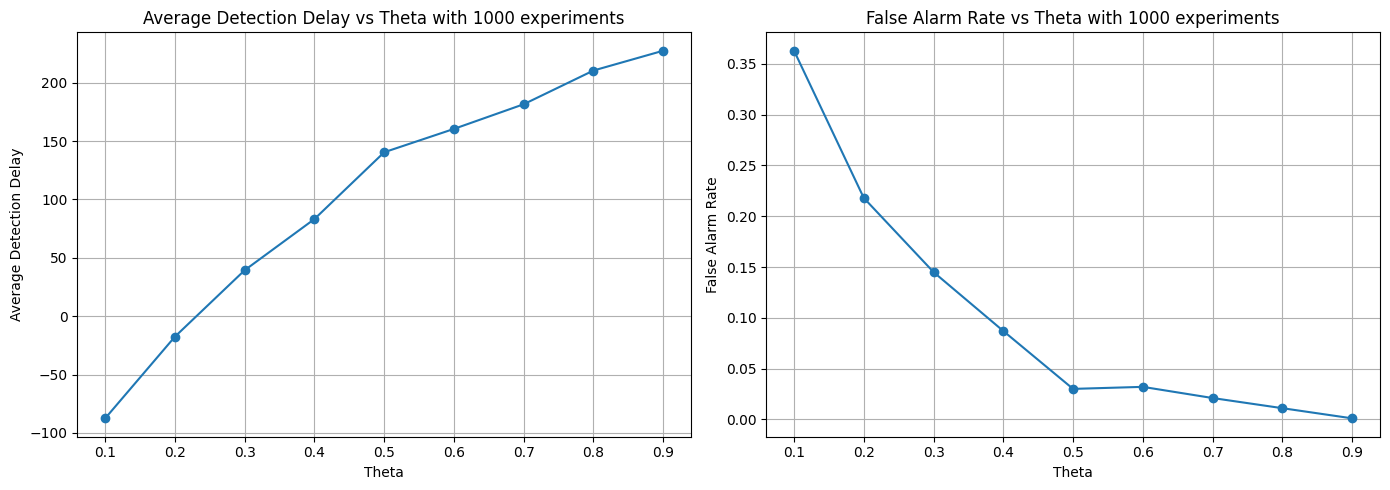

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_ar_data(n, change_point, mean0, variance0, mean1, variance1, theta):
    """
    生成自回归模型的合成数据
    """
    data = np.zeros(n)
    data[0] = mean0

    # 变化点之前的数据
    for t in range(1, change_point):
        data[t] = data[t-1] + (1 - theta) * (mean0 - data[t-1]) + np.random.normal(0, np.sqrt(variance0))

    # 变化点之后的数据
    for t in range(change_point, n):
        data[t] = data[t-1] + (1 - theta) * (mean1 - data[t-1]) + np.random.normal(0, np.sqrt(variance1))

    return data

def cusum(data, h):
    """
    执行CuSum算法并返回检测到变化的时间点、正向和负向累积和列表
    """
    s_pos = 0
    s_neg = 0
    s_pos_list = [0]
    s_neg_list = [0]

    for i in range(1, len(data)):
        s_pos = max(0, s_pos + data[i] - data[i-1] - h)
        s_neg = min(0, s_neg + data[i] - data[i-1] + h)

        s_pos_list.append(s_pos)
        s_neg_list.append(s_neg)

        if s_pos >= h or s_neg <= -h:
            return i, s_pos_list, s_neg_list
    return len(data), s_pos_list, s_neg_list

def run_ar_experiment(n, change_point, mean0, variance0, mean1, variance1, theta_values, h, num_experiments=1000):
    """
    运行自回归数据生成和CuSum检测实验，并可视化结果
    """
    all_results = {theta: {'delays': [], 'false_alarms': []} for theta in theta_values}

    for theta in theta_values:
        for _ in tqdm(range(num_experiments)):
            data = generate_ar_data(n, change_point, mean0, variance0, mean1, variance1, theta)
            detection_time, s_pos_list, s_neg_list = cusum(data, h)
            delay = detection_time - change_point
            all_results[theta]['delays'].append(delay)
            if detection_time < change_point:
                all_results[theta]['false_alarms'].append(1)
            else:
                all_results[theta]['false_alarms'].append(0)

    avg_delays = {theta: np.mean(all_results[theta]['delays']) for theta in theta_values}
    false_alarm_rates = {theta: np.mean(all_results[theta]['false_alarms']) for theta in theta_values}

    # 可视化平均检测延迟和误报率
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(theta_values, [avg_delays[theta] for theta in theta_values], marker='o')
    plt.title('Average Detection Delay vs Theta with 1000 experiments')
    plt.xlabel('Theta')
    plt.ylabel('Average Detection Delay ')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(theta_values, [false_alarm_rates[theta] for theta in theta_values], marker='o')
    plt.title('False Alarm Rate vs Theta with 1000 experiments')
    plt.xlabel('Theta')
    plt.ylabel('False Alarm Rate')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return avg_delays, false_alarm_rates

# 参数设置
n = 1000  # 数据点总数
change_point = 700  # 分布变化点
mean0, variance0 = 4, 1  # 变化前的均值和方差
mean1, variance1 = 6, 2  # 变化后的均值和方差
theta_values = np.linspace(0.1, 0.9, 9)  # 不同的theta值
h = 2.3  # 阈值

# 运行实验
avg_delays, false_alarm_rates = run_ar_experiment(n, change_point, mean0, variance0, mean1, variance1, theta_values, h)
